# Regression Project: Airbnb Pricing Analytics

In [1]:
import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import lightgbm as lgb
import catboost
import optuna
import warnings
from scipy.stats import kurtosis
from scipy.stats import skew

# Methods
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from catboost import CatBoostRegressor

# Model selection and evaluation tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error, mean_squared_log_error

# 1. Load Dataset

In [2]:
df = pd.read_csv('train.csv') 
df_test = pd.read_csv('test.csv')

# 2. Data Preprocessing/Feature Engineering

In [3]:
df.describe().round(3) #presenting measurable information

,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,12941.000,12941.000,0.0,12941.000,12941.000,12941.000,12030.000,12446.000,12941.000,12941.000,...,9093.000,9081.000,9092.000,9081.000,9076.000,12941.000,12941.000,12941.000,12941.000,9426.000
mean,11.660,11.660,NaN,-33.858,151.204,3.569,1.772,2.111,60.230,897.749,...,4.613,4.834,4.832,4.832,4.635,8.527,7.484,0.979,0.029,0.680
std,43.015,43.015,NaN,0.080,0.089,2.194,1.057,1.526,51.518,413.525,...,0.601,0.414,0.433,0.360,0.520,26.204,25.489,6.347,0.362,1.187
min,0.000,0.000,NaN,-34.092,150.630,1.000,1.000,1.000,1.000,1.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.010
25%,1.000,1.000,NaN,-33.898,151.180,2.000,1.000,1.000,3.000,1124.000,...,4.500,4.850,4.850,4.810,4.500,1.000,0.000,0.000,0.000,0.060
50%,1.000,1.000,NaN,-33.881,151.217,3.000,1.000,2.000,90.000,1125.000,...,4.810,5.000,5.000,4.960,4.770,1.000,1.000,0.000,0.000,0.210
75%,3.000,3.000,NaN,-33.824,151.264,4.000,2.000,3.000,90.000,1125.000,...,5.000,5.000,5.000,5.000,5.000,2.000,1.000,1.000,0.000,0.890
max,457.000,457.000,NaN,-33.399,151.340,16.000,18.000,39.000,1125.000,1224.000,...,5.000,5.000,5.000,5.000,5.000,197.000,197.000,100.000,8.000,44.490


In [4]:
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['log_price'] = np.log(df['price'])

4.8212143130378164
33.14515482806888


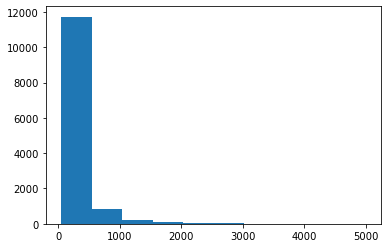

In [5]:
plt.hist(df['price'].astype(float))
#calculate sample skewness
print(skew(df['price'], bias=False))
#calculate sample kurtosis
print(kurtosis(df['price'], bias=False))

0.9159338842375208
0.7337225192245822


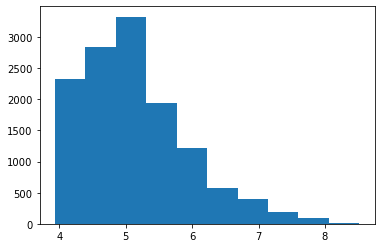

In [6]:
#Data is heavily skewed, log transformation is required to achieve approx. normal for future analysis

plt.hist(df['log_price'].astype(float))
#calculate sample skewness
print(skew(df['log_price'], bias=False))
#calculate sample kurtosis
print(kurtosis(df['log_price'], bias=False))

In [7]:
df["bathroom_qty"] = df["bathrooms_text"].str.split(" ", expand=True)[0]
df["bathroom_type"] = df["bathrooms_text"].str.split(" ", expand=True)[1]
df['bathroom_qty'] = df['bathroom_qty'].replace(['Shared'],1)
df['bathroom_qty'] = df['bathroom_qty'].replace(['Half-bath'],1)
df['bathroom_qty'] = df['bathroom_qty'].replace(['Private'],1)

df_test["bathroom_qty"] = df_test["bathrooms_text"].str.split(" ", expand=True)[0]
df_test["bathroom_type"] = df_test["bathrooms_text"].str.split(" ", expand=True)[1]
df_test['bathroom_qty'] = df_test['bathroom_qty'].replace(['Shared'],1)
df_test['bathroom_qty'] = df_test['bathroom_qty'].replace(['Half-bath'],1)
df_test['bathroom_qty'] = df_test['bathroom_qty'].replace(['Private'],1)

In [8]:
df['reviews_per_month'].fillna(int(df['reviews_per_month'].mean()), inplace=True)
df['bedrooms'].fillna('0', inplace = True)
df['beds'].fillna('0', inplace = True) 
df['bathroom_qty'].fillna('0', inplace = True)
df['bathroom_qty'] = df['bathroom_qty'].astype(float)
df['bedrooms'] = df['bedrooms'].astype(int)
df['beds'] = df['beds'].astype(int)

df_test['reviews_per_month'].fillna(int(df_test['reviews_per_month'].mean()), inplace=True)
df_test['bedrooms'].fillna('0', inplace = True)
df_test['beds'].fillna('0', inplace = True)
df_test['bathroom_qty'].fillna('0', inplace = True)
df_test['bathroom_qty'] = df_test['bathroom_qty'].astype(float)
df_test['bedrooms'] = df_test['bedrooms'].astype(int)
df_test['beds'] = df_test['beds'].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12941 entries, 0 to 12940
Data columns (total 64 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   name                                          12941 non-null  object 
 1   description                                   12537 non-null  object 
 2   neighborhood_overview                         8013 non-null   object 
 3   host_name                                     12941 non-null  object 
 4   host_since                                    12941 non-null  object 
 5   host_location                                 12930 non-null  object 
 6   host_about                                    7174 non-null   object 
 7   host_response_time                            5086 non-null   object 
 8   host_response_rate                            5086 non-null   object 
 9   host_acceptance_rate                          5637 non-null  

In [9]:
variable = 'property_type'

new_property_type = df[variable].value_counts() 
for level in new_property_type.index:
    if new_property_type[level] < 250:
        df.loc[df[variable]==level, variable] = 'Other'
        
new_property_type = df_test[variable].value_counts() 
for level in new_property_type.index:
    if new_property_type[level] < 250:
        df_test.loc[df_test[variable]==level, variable] = 'Other'

In [10]:
for c in df.columns:
    col_type = df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df[c] = df[c].astype('category')
        
for q in df_test.columns:
    col_type = df_test[q].dtype
    if col_type == 'object' or col_type.name == 'category':
        df_test[q] = df_test[q].astype('category')

In [11]:
response = 'log_price' 
predictors= ['accommodates','bedrooms','latitude', 'longitude','bathroom_qty','property_type',
             'number_of_reviews','neighbourhood_cleansed','host_is_superhost', 'reviews_per_month',
            'availability_365', 'availability_30']

knn_predictors= ['accommodates','bedrooms','latitude', 'longitude','bathroom_qty',
             'number_of_reviews', 'reviews_per_month', 'availability_365', 'availability_30']
    
cat_col = df[predictors].select_dtypes('category').columns.tolist()
    
index_train, index_valid  = train_test_split(np.array(df.index), train_size = 0.2, random_state=1)

train = df.loc[index_train,:].copy()
valid =  df.loc[index_valid,:].copy()

y_train = train[response]
y_valid = valid[response]
X_train = train[predictors]
X_valid = valid[predictors]
knn_X_train = train[knn_predictors]
knn_X_valid = valid[knn_predictors]

# 3. Models

## 3.1 KNN

In [12]:
#kNN based on Euclidean distance
knn1 = KNeighborsRegressor(n_neighbors = 1) 
knn1.fit(knn_X_train, y_train)

knn2 = KNeighborsRegressor(n_neighbors = 3) 
knn2.fit(knn_X_train, y_train)


KNeighborsRegressor(n_neighbors=3)

## 3.2 LightGBM

### 3.2.1 Hyperparameter optimisation

In [13]:
# We have to reconstruct the dataset to tune min_data_in_leaf
train_data = lgb.Dataset(X_train, y_train)
valid_data = lgb.Dataset(X_valid, y_valid, reference = train_data)

from optuna.samplers import TPESampler

def objective(trial):
    
    params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.30, step=0.01), 
    'num_iterations': trial.suggest_int('num_iterations', 10, 1000),
    'num_leaves': trial.suggest_int('num_leaves', 2, 72),
    'max_depth': trial.suggest_int("max_depth", 3, 36),
    'lambda_l1': trial.suggest_loguniform('lambda_l1',  1e-8, 10), 
    'lambda_l2': trial.suggest_loguniform('lambda_l2',  1e-8, 10), 
    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 20),
    'feature_fraction':  trial.suggest_uniform('feature_fraction', 0.5, 1.0),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 128), 
    'feature_pre_filter': False,
    'verbosity': -1,
     }
    
    # Cross-validation 
    history = lgb.cv(params, train_data, num_boost_round = 5000, 
                 nfold = 5, stratified = False, early_stopping_rounds = 50)
    
    # Save full set of parameters
    trial.set_user_attr('params', params)
    
    # Save the number of boosting iterations selected by early stopping
    trial.set_user_attr('num_boost_round', len(history['l2-mean']))
    
    return history['l2-mean'][-1] # returns CV error for the best trial

sampler = TPESampler(seed = 42) 
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=500, timeout = 120)  

# Important! The higher the timeout, the better the chances of finding a good configuration. 
# The time budget should be much higher in a real application.

[I 2022-08-16 14:49:10,371] A new study created in memory with name: no-name-5bf6280c-eef8-4296-9756-aa2fb5771c4a
C:\Users\wongj\anaconda3\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\wongj\anaconda3\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-08-16 14:49:10,936] Trial 0 finished with value: 0.19709372904975941 and parameters: {'learning_rate': 0.12, 'num_iterations': 952, 'num_leaves': 53, 'max_depth': 23, 'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07, 'bagging_fraction': 0.5290418060840998, 'bagging

C:\Users\wongj\anaconda3\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\wongj\anaconda3\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-08-16 14:49:16,521] Trial 8 finished with value: 0.1893994079636421 and parameters: {'learning_rate': 0.26, 'num_iterations': 627, 'num_leaves': 25, 'max_depth': 5, 'lambda_l1': 6.292756043818863e-06, 'lambda_l2': 8.445977074223802e-06, 'bagging_fraction': 0.864803089169032, 'bagging_freq': 13, 'feature_fraction': 0.9436063712881633, 'min_data_in_leaf': 61}. Best is trial 1 with value: 0.183628961668

C:\Users\wongj\anaconda3\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\wongj\anaconda3\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-08-16 14:49:27,537] Trial 16 finished with value: 0.18848754707888554 and parameters: {'learning_rate': 0.12, 'num_iterations': 662, 'num_leaves': 49, 'max_depth': 20, 'lambda_l1': 0.0030242975914927706, 'lambda_l2': 0.0016734340975457281, 'bagging_fraction': 0.702413389619678, 'bagging_freq': 14, 'feature_fraction': 0.5970005064728328, 'min_data_in_leaf': 29}. Best is trial 11 with value: 0.18217740

C:\Users\wongj\anaconda3\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\wongj\anaconda3\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-08-16 14:49:34,761] Trial 24 finished with value: 0.18381533139334758 and parameters: {'learning_rate': 0.09999999999999999, 'num_iterations': 714, 'num_leaves': 34, 'max_depth': 19, 'lambda_l1': 0.0011839352280227872, 'lambda_l2': 7.763511740928513e-05, 'bagging_fraction': 0.8062291366913521, 'bagging_freq': 9, 'feature_fraction': 0.7104033938204213, 'min_data_in_leaf': 36}. Best is trial 11 with va

C:\Users\wongj\anaconda3\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\wongj\anaconda3\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-08-16 14:49:47,012] Trial 32 finished with value: 0.18062329830595586 and parameters: {'learning_rate': 0.03, 'num_iterations': 956, 'num_leaves': 46, 'max_depth': 24, 'lambda_l1': 0.08927619913286522, 'lambda_l2': 1.47658968511976e-07, 'bagging_fraction': 0.7723499032147975, 'bagging_freq': 19, 'feature_fraction': 0.695508817741261, 'min_data_in_leaf': 1}. Best is trial 32 with value: 0.180623298305

[I 2022-08-16 14:50:03,080] Trial 40 finished with value: 0.1874725202408206 and parameters: {'learning_rate': 0.21000000000000002, 'num_iterations': 338, 'num_leaves': 44, 'max_depth': 13, 'lambda_l1': 2.0075911186069946, 'lambda_l2': 0.6164499086329307, 'bagging_fraction': 0.895040119743633, 'bagging_freq': 1, 'feature_fraction': 0.5356398668016673, 'min_data_in_leaf': 22}. Best is trial 32 with value: 0.18062329830595586.
C:\Users\wongj\anaconda3\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\wongj\anaconda3\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future relea

C:\Users\wongj\anaconda3\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\wongj\anaconda3\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-08-16 14:50:26,095] Trial 49 finished with value: 0.18361311168223018 and parameters: {'learning_rate': 0.02, 'num_iterations': 703, 'num_leaves': 58, 'max_depth': 14, 'lambda_l1': 0.006411439279671893, 'lambda_l2': 1.9272141860722713e-06, 'bagging_fraction': 0.8131222395607001, 'bagging_freq': 2, 'feature_fraction': 0.7783322158114823, 'min_data_in_leaf': 42}. Best is trial 32 with value: 0.18062329

[I 2022-08-16 14:50:45,612] Trial 57 finished with value: 0.183240460470319 and parameters: {'learning_rate': 0.060000000000000005, 'num_iterations': 861, 'num_leaves': 42, 'max_depth': 6, 'lambda_l1': 3.958325320227534, 'lambda_l2': 3.4474409788825728e-06, 'bagging_fraction': 0.7177225715119585, 'bagging_freq': 3, 'feature_fraction': 0.6479090188278059, 'min_data_in_leaf': 16}. Best is trial 32 with value: 0.18062329830595586.
C:\Users\wongj\anaconda3\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\wongj\anaconda3\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future re

[I 2022-08-16 14:51:02,514] Trial 65 finished with value: 0.1806754855476111 and parameters: {'learning_rate': 0.01, 'num_iterations': 781, 'num_leaves': 40, 'max_depth': 22, 'lambda_l1': 0.003913560863027583, 'lambda_l2': 0.0007831609468085407, 'bagging_fraction': 0.8791716340583443, 'bagging_freq': 1, 'feature_fraction': 0.6982358481543818, 'min_data_in_leaf': 24}. Best is trial 61 with value: 0.17961275719456457.
C:\Users\wongj\anaconda3\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\wongj\anaconda3\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of Lig

In [14]:
params = study.best_trial.user_attrs['params']
num_trees = study.best_trial.user_attrs['num_boost_round']

print(f'Number of boosting iterations: {num_trees} \n')

print('Best parameters:')
params 

Number of boosting iterations: 139 

Best parameters:


{'objective': 'regression',
 'boosting_type': 'gbdt',
 'learning_rate': 0.04,
 'num_iterations': 935,
 'num_leaves': 38,
 'max_depth': 25,
 'lambda_l1': 0.03689131909182309,
 'lambda_l2': 0.00023523070467906576,
 'bagging_fraction': 0.8467744423511414,
 'bagging_freq': 2,
 'feature_fraction': 0.5549246344951578,
 'min_data_in_leaf': 5,
 'feature_pre_filter': False,
 'verbosity': -1}

In [15]:
importance = optuna.importance.get_param_importances(study)

importance

OrderedDict([('num_iterations', 0.37460866286706834),
             ('learning_rate', 0.3095228817075466),
             ('bagging_fraction', 0.10359164124410092),
             ('num_leaves', 0.08823053333360571),
             ('min_data_in_leaf', 0.036283574363882756),
             ('feature_fraction', 0.03137141655017135),
             ('max_depth', 0.023686885619542346),
             ('lambda_l1', 0.020934947196929905),
             ('bagging_freq', 0.009319142553982411),
             ('lambda_l2', 0.002450314563169818)])

### 3.2.2 Model Building

In [16]:
params = {
 'objective': 'regression',
 'boosting_type': 'gbdt',
 'learning_rate': 0.04,
 'num_iterations': 935,
 'num_leaves': 38,
 'max_depth': 25,
 'lambda_l1': 0.03689131909182309,
 'lambda_l2': 0.00023523070467906576,
 'bagging_fraction': 0.8467744423511414,
 'bagging_freq': 2,
 'feature_fraction': 0.5549246344951578,
 'min_data_in_leaf': 5}

lgbm = lgb.train(params, train_data, num_boost_round = 432 , verbose_eval = False)

C:\Users\wongj\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\wongj\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Number of data points in the train set: 2588, number of used features: 12
[LightGBM] [Info] Start training from score 5.118759


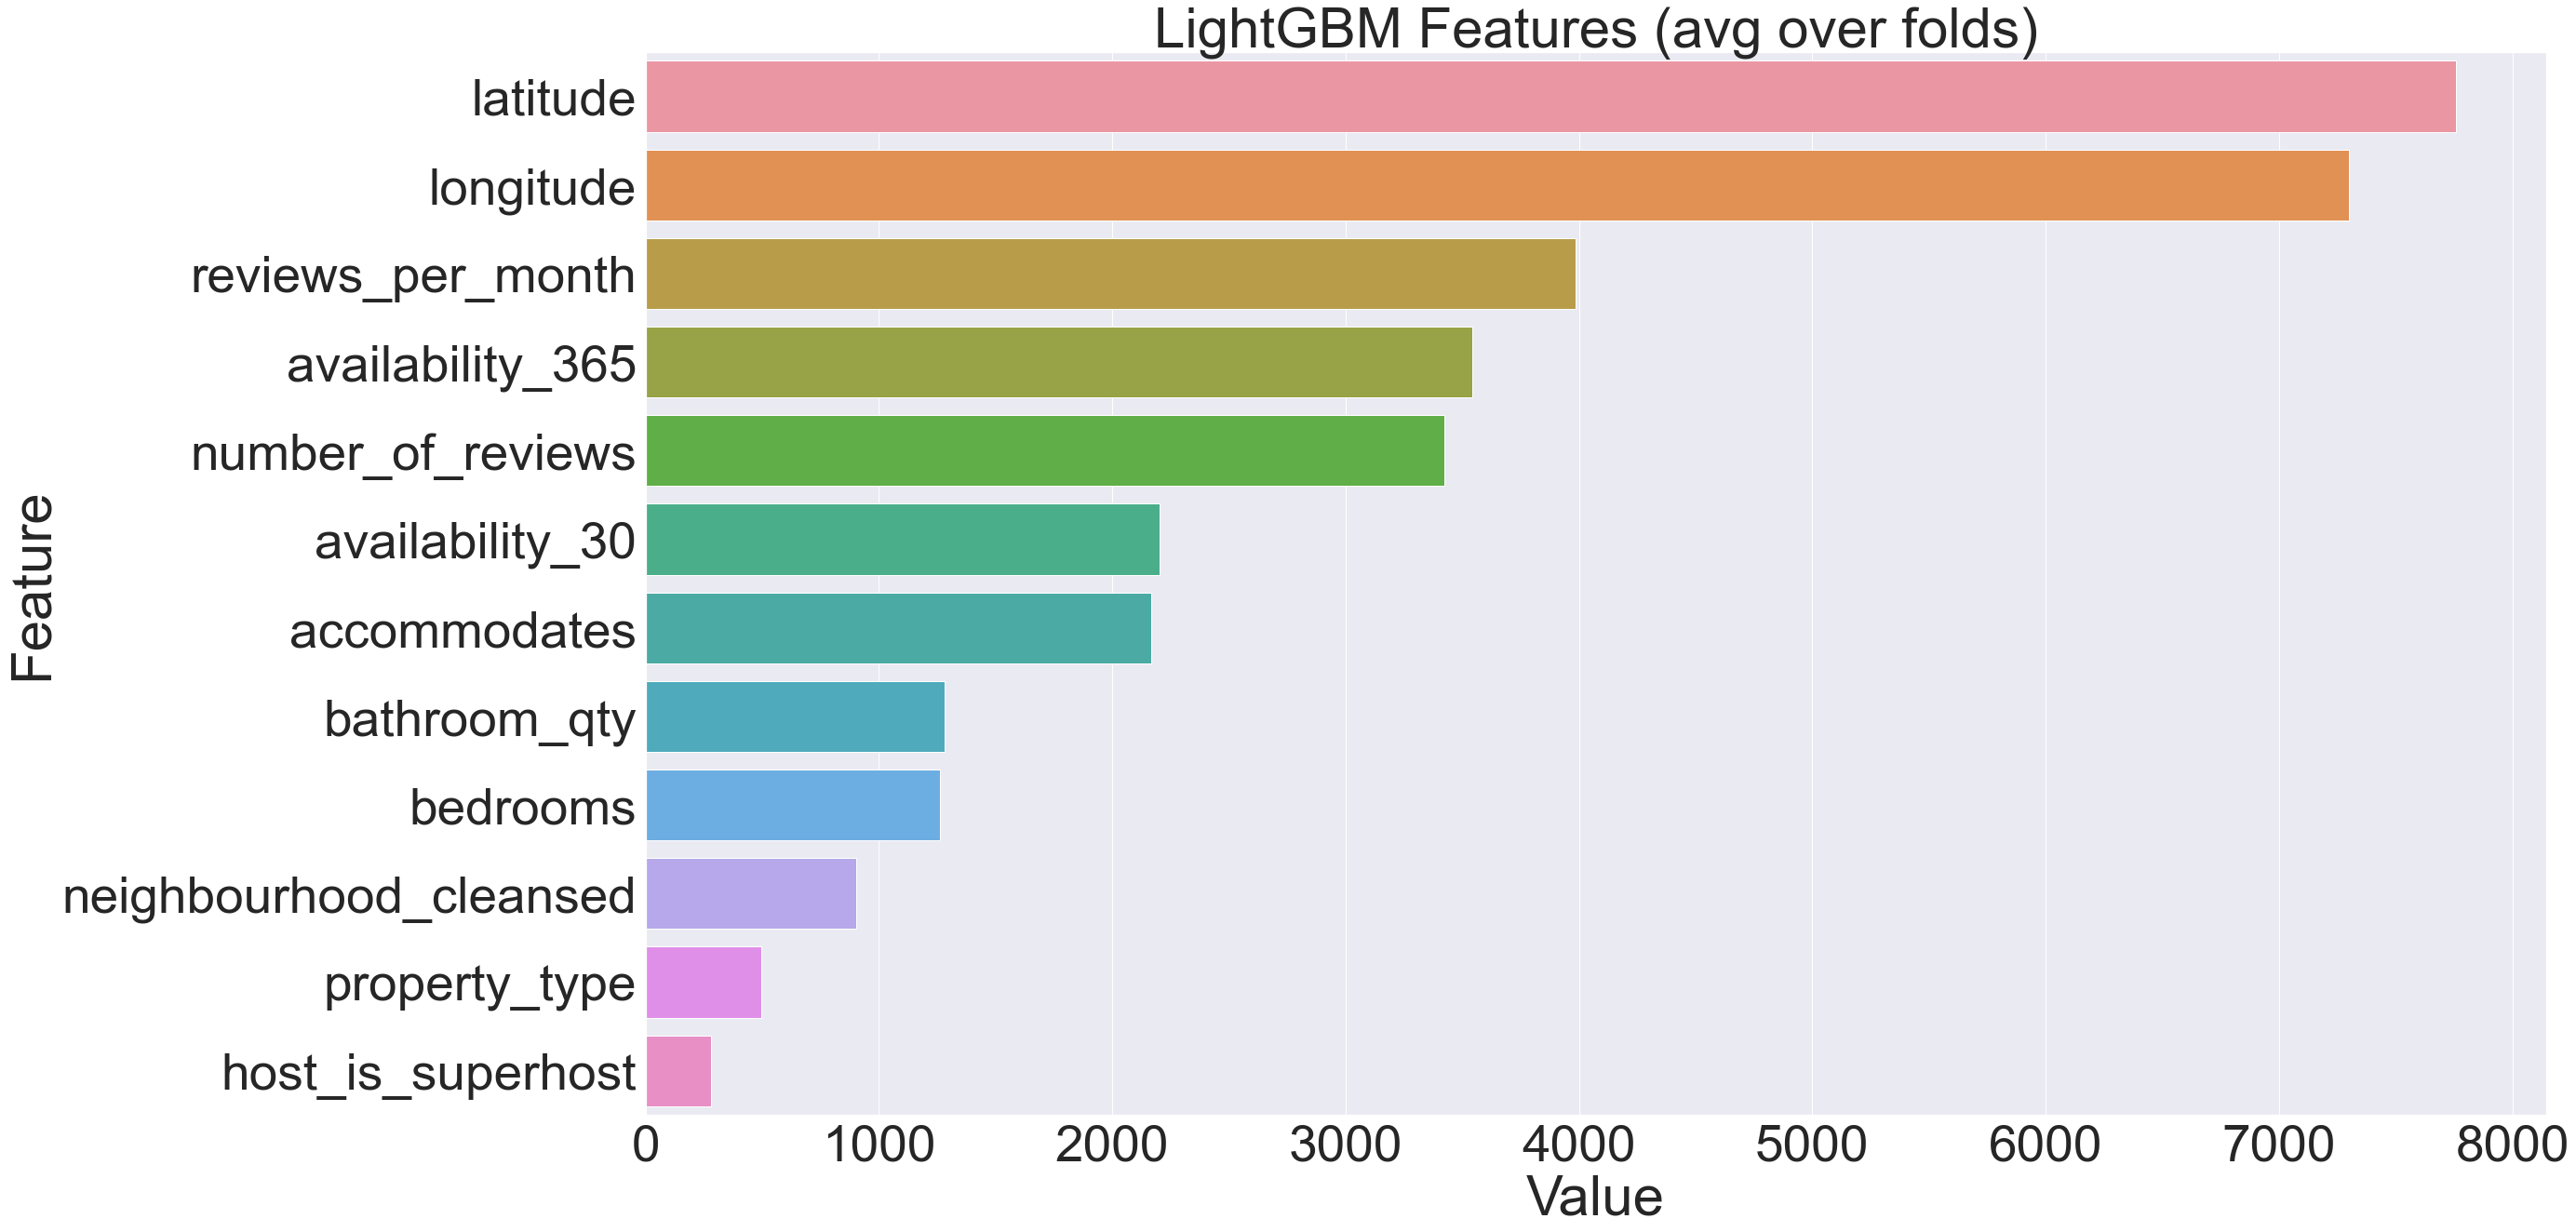

In [17]:
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    
plotImp(lgbm,X_train)

## 3.3 CatBoost

In [18]:
cb = CatBoostRegressor(loss_function='RMSE', verbose=0)        
cb.fit(X_train, y_train,cat_features = cat_col)

## 3.4 Model Stack

In [19]:
stack = StackingRegressor(estimators = [ ('KNN_1',knn1 ), ('KNN_2', knn2)], final_estimator = LinearRegression(), 
                           cv = 5)

stack.fit(knn_X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('KNN_1', KNeighborsRegressor(n_neighbors=1)),
                              ('KNN_2', KNeighborsRegressor(n_neighbors=3))],
                  final_estimator=LinearRegression())

In [20]:
stack.final_estimator_.coef_

array([0.0862951 , 0.66523193])

# 4. Model Selection

In [21]:
columns=['Test RMSE', 'Test R$^2$', 'Test MAE']
rows=['CatBoost', 'LightGBM']

results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods = [cb, lgbm]

for i, method in enumerate(methods):

    y_pred = method.predict(X_valid)
    
    results.iloc[i,0] = np.sqrt(mean_squared_error(y_valid, y_pred))
    results.iloc[i,1] = r2_score(y_valid, y_pred)
    results.iloc[i,2] = mean_absolute_error(y_valid, y_pred)
    

results.round(3)

,Test RMSE,Test R$^2$,Test MAE
CatBoost,0.426,0.713,0.323
LightGBM,0.440,0.695,0.334


In [22]:
columns=['Test RMSE', 'Test R$^2$', 'Test MAE']
rows=['KNN (k = 1)', 'KNN (k = 3)', 'Stack']
results = pd.DataFrame(0.0, columns=columns, index=rows)

# List of models
models = [knn1, knn2, stack] 

# Compute predictions and metrics
for i, model in enumerate(models):
    
    y_pred = model.predict(knn_X_valid) 
    
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_valid, y_pred))
    results.iloc[i, 1] = r2_score(y_valid, y_pred)
    results.iloc[i, 2] = mean_absolute_error(y_valid, y_pred) 

results.round(3)

,Test RMSE,Test R$^2$,Test MAE
KNN (k = 1),0.777,0.046,0.597
KNN (k = 3),0.659,0.315,0.506
Stack,0.644,0.345,0.501


# 5. Prediction

In [23]:
X_test = df_test[predictors]

In [24]:
y_pred_lgbm = lgbm.predict(X_test)

df_pred_lgbm = pd.DataFrame(y_pred_lgbm, columns = ['log_price'])
df_pred_lgbm['price'] = np.exp(df_pred_lgbm['log_price'])

df_pred_lgbm

,log_price,price
0,5.345524,209.667755
1,4.119271,61.514406
2,4.494887,89.558091
3,4.992021,147.233609
4,5.507715,246.586990
...,...,...
5542,4.648234,104.400414
5543,4.615861,101.074851
5544,5.605941,272.037685
5545,5.291052,198.552108


In [25]:
y_pred_cb = cb.predict(X_test)

df_pred_cb = pd.DataFrame(y_pred_cb, columns = ['log_price'])
df_pred_cb['price'] = np.exp(df_pred_cb['log_price'])

df_pred_cb


,log_price,price
0,5.486887,241.504121
1,4.071601,58.650776
2,4.624374,101.938969
3,5.011492,150.128486
4,5.572047,262.971899
...,...,...
5542,4.992637,147.324341
5543,4.102212,60.473926
5544,5.635907,280.313022
5545,5.228270,186.469939
